# Prerequisits

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing 

import kerastuner as kt
from kerastuner.tuners import RandomSearch

C:\Users\320148~1\AppData\Local\Temp/ipykernel_9264/3085796545.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Read Data

In [2]:
data=pd.read_csv('gt_2012.csv')
data.shape

(7628, 11)

In [3]:
data.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [4]:
data.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AT,7628.0,18.397950,7.661038,0.522300,12.269250,19.12050,24.337250,34.9290
AP,7628.0,1012.258153,6.384291,985.850000,1008.400000,1012.00000,1016.000000,1031.8000
AH,7628.0,79.074804,14.105087,30.344000,69.165250,82.41150,90.356250,100.2000
AFDP,7628.0,4.306717,0.831170,2.087400,3.882650,4.29805,4.670525,7.6106
GTEP,7628.0,25.181361,4.006825,18.100000,23.090750,25.22100,26.322250,37.4020
TIT,7628.0,1082.890233,16.852148,1024.600000,1075.800000,1089.10000,1093.800000,1100.8000
TAT,7628.0,546.263793,7.331345,513.060000,547.657500,549.92000,550.070000,550.5300
TEY,7628.0,132.675552,15.302140,101.150000,125.240000,133.76000,134.900000,174.6100
CDP,7628.0,12.000121,1.049384,9.928600,11.469750,12.04100,12.290000,15.0810
CO,7628.0,2.361133,2.474116,0.007505,1.127125,1.63630,2.953025,44.1030


In [6]:
features=data.columns

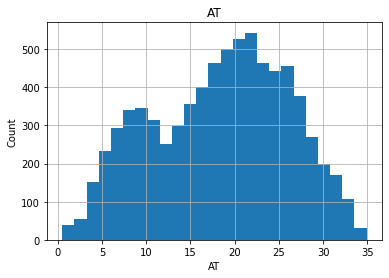

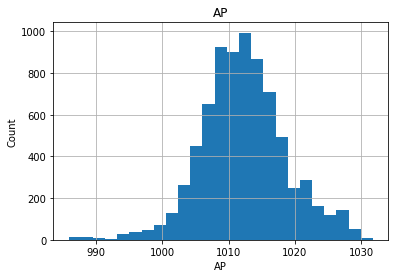

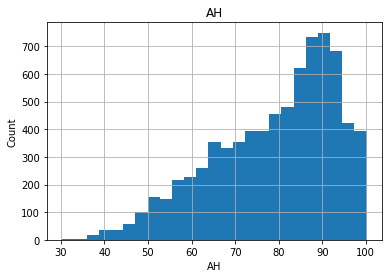

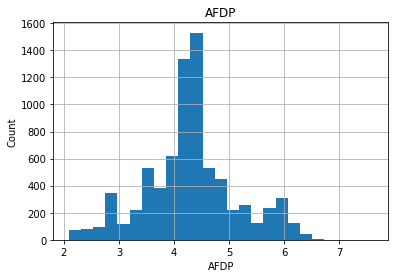

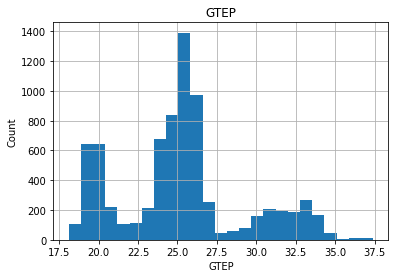

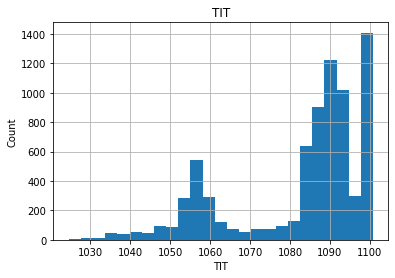

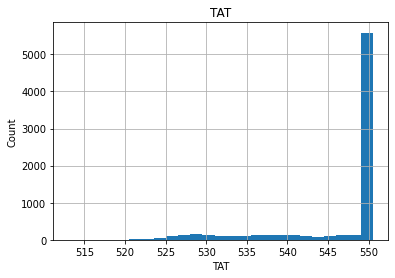

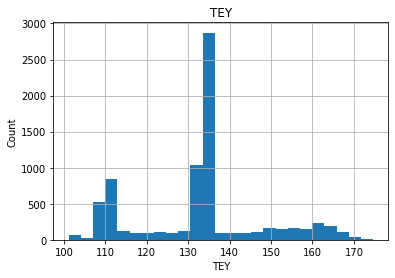

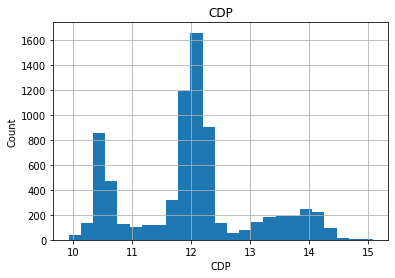

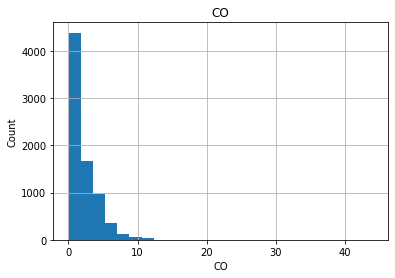

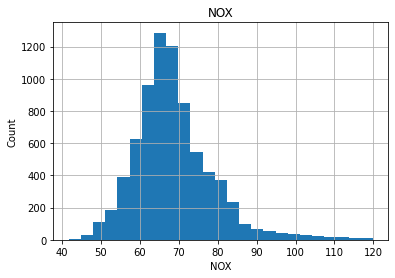

In [7]:
for feature in features:
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [8]:
for feature in data.columns:
    data[feature]=np.log(data[feature])

# Scaling

In [9]:
feature_scale=[feature for feature in data.columns if feature not in ['NOX']]

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(data[feature_scale])

MinMaxScaler()

In [10]:
scaler.transform(data[feature_scale])

array([[0.612714  , 0.48555767, 0.97109291, ..., 0.23026903, 0.157664  ,
        0.69608003],
       [0.61011915, 0.49644446, 0.9738471 , ..., 0.23058839, 0.15608444,
        0.69902255],
       [0.61403883, 0.50515001, 0.96362236, ..., 0.23042872, 0.15676152,
        0.69776603],
       ...,
       [0.69934915, 0.79051331, 0.87806439, ..., 0.50828233, 0.43609482,
        0.60323213],
       [0.70302498, 0.79051331, 0.88463937, ..., 0.50416158, 0.41532319,
        0.60216432],
       [0.70380684, 0.78621718, 0.89142948, ..., 0.17416504, 0.15314819,
        0.80345593]])

In [11]:
data = pd.concat([data[['NOX']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(data[feature_scale]), columns=feature_scale)],
                    axis=1)

In [12]:
data.head()

,NOX,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO
0,4.415486,0.612714,0.485558,0.971093,0.399532,0.114116,0.462977,0.986336,0.230269,0.157664,0.696080
1,4.416138,0.610119,0.496444,0.973847,0.399488,0.118663,0.464293,0.986336,0.230588,0.156084,0.699023
2,4.412410,0.614039,0.505150,0.963622,0.395635,0.122220,0.465609,0.982982,0.230429,0.156762,0.697766
3,4.414857,0.619468,0.513852,0.957580,0.395213,0.123125,0.468241,0.986078,0.230588,0.157890,0.697445
4,4.410505,0.630693,0.524725,0.956709,0.399002,0.121245,0.469556,0.985820,0.230588,0.159243,0.699453


# Feature selection

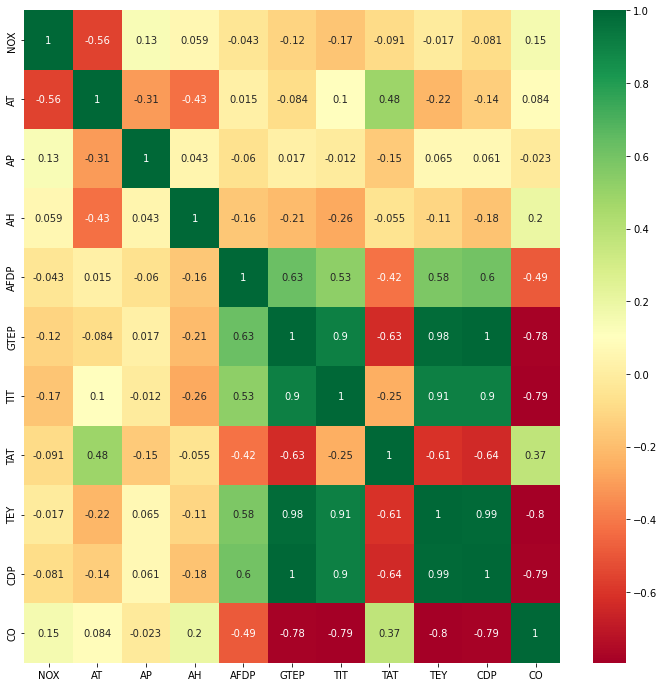

In [13]:
corr_mat = data.corr()
top_corr_features = corr_mat.index
plt.figure(figsize =(12,12))
g= sns.heatmap(data[top_corr_features].corr(),annot=True,cmap='RdYlGn')

In [14]:
df=data.copy()

In [15]:
df.drop(axis=1,columns=['TIT','TEY','CDP'],inplace=True)

# Spliting data into train and test

In [18]:
y=df.pop('NOX')
X=df.copy()

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.20, random_state=42)

# Models
1. ANN
2. linear Regression
3. Polynomial regression
4. Random Forest Regressor

### ANN

In [58]:
def build_model(hp):
    model = keras.Sequential()
    for i in range (hp.Int('num_layers',2,20)):
        model.add(layers.Dense(units = hp.Int('units_'+str(i), min_value=32, max_value=512, step=32), activation='relu'))
    model.add(layers.Dense(1, activation ='linear'))
    model.compile(
    optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',[1e-2,1e-3,1e-4])),                    #choice chooses between the given values
    loss= 'mean_squared_error',
    metrics = ['mean_squared_error'])
    return model  #INT try with different values itself

In [59]:
tuner = RandomSearch(build_model,
                     objective ='val_mean_squared_error',
                     max_trials=4,
                     executions_per_trial =3,
                     directory ='proj',
                     project_name = 'compo')

In [60]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [61]:
tuner.search(X_train, y_train,
    validation_split=0.2, epochs=50)

Trial 4 Complete [00h 03m 33s]
val_mean_squared_error: 0.0034553532022982836

Best val_mean_squared_error So Far: 0.00248790990250806
Total elapsed time: 00h 11m 41s
INFO:tensorflow:Oracle triggered exit


In [63]:
tuner.results_summary()

Results summary
Results in proj\compo
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 13
units_0: 352
units_1: 320
learning_rate: 0.001
units_2: 256
units_3: 416
units_4: 416
units_5: 352
units_6: 64
units_7: 256
units_8: 160
units_9: 224
units_10: 256
units_11: 320
units_12: 256
units_13: 128
Score: 0.00248790990250806
Trial summary
Hyperparameters:
num_layers: 8
units_0: 448
units_1: 128
learning_rate: 0.01
units_2: 128
units_3: 384
units_4: 384
units_5: 384
units_6: 160
units_7: 160
units_8: 384
units_9: 192
units_10: 64
units_11: 448
units_12: 96
units_13: 96
Score: 0.0034553532022982836
Trial summary
Hyperparameters:
num_layers: 14
units_0: 320
units_1: 32
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
Score: 0.004451127101977666
Trial summary
Hyperparameters:
num_layers: 3
units_0: 12

In [99]:
def build_and_compile_model(norm):
    model = keras.Sequential([
    norm,
    layers.Dense(352, activation='relu'), #0
    layers.Dense(320, activation='relu'),  #1
    layers.Dense(256, activation='relu'),   #2
    layers.Dense(416, activation='relu'),   #3
    layers.Dense(416, activation='relu'),    #4 
    layers.Dense(352, activation='relu'),   #5
    layers.Dense(64, activation='relu'),   #6
    layers.Dense(256, activation='relu'), #7
    layers.Dense(160, activation='relu'), #8
    layers.Dense(224, activation='relu'), #9
    layers.Dense(256, activation='relu'), #10
    layers.Dense(320, activation='relu'), #11
    layers.Dense(64, activation='relu'), #12
    layers.Dense(1, activation='linear')
    ])
    model.compile(loss='mean_squared_error',
      optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [100]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

In [183]:
model = build_and_compile_model(normalizer)

In [185]:
%%time
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=50,
    verbose=2, epochs=500)

Epoch 1/500
98/98 - 7s - loss: 2.7692 - val_loss: 0.1339 - 7s/epoch - 71ms/step
Epoch 2/500
98/98 - 2s - loss: 0.0647 - val_loss: 0.0280 - 2s/epoch - 17ms/step
Epoch 3/500
98/98 - 2s - loss: 0.0186 - val_loss: 0.0121 - 2s/epoch - 18ms/step
Epoch 4/500
98/98 - 2s - loss: 0.0085 - val_loss: 0.0076 - 2s/epoch - 17ms/step
Epoch 5/500
98/98 - 2s - loss: 0.0057 - val_loss: 0.0062 - 2s/epoch - 18ms/step
Epoch 6/500
98/98 - 2s - loss: 0.0043 - val_loss: 0.0043 - 2s/epoch - 17ms/step
Epoch 7/500
98/98 - 2s - loss: 0.0033 - val_loss: 0.0044 - 2s/epoch - 18ms/step
Epoch 8/500
98/98 - 2s - loss: 0.0031 - val_loss: 0.0031 - 2s/epoch - 17ms/step
Epoch 9/500
98/98 - 2s - loss: 0.0029 - val_loss: 0.0032 - 2s/epoch - 18ms/step
Epoch 10/500
98/98 - 2s - loss: 0.0026 - val_loss: 0.0030 - 2s/epoch - 18ms/step
Epoch 11/500
98/98 - 2s - loss: 0.0027 - val_loss: 0.0033 - 2s/epoch - 18ms/step
Epoch 12/500
98/98 - 2s - loss: 0.0027 - val_loss: 0.0032 - 2s/epoch - 17ms/step
Epoch 13/500
98/98 - 2s - loss: 0.002

Epoch 103/500
98/98 - 2s - loss: 0.0013 - val_loss: 0.0022 - 2s/epoch - 18ms/step
Epoch 104/500
98/98 - 2s - loss: 0.0015 - val_loss: 0.0021 - 2s/epoch - 18ms/step
Epoch 105/500
98/98 - 2s - loss: 0.0013 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 106/500
98/98 - 2s - loss: 0.0025 - val_loss: 0.0028 - 2s/epoch - 18ms/step
Epoch 107/500
98/98 - 2s - loss: 0.0018 - val_loss: 0.0021 - 2s/epoch - 18ms/step
Epoch 108/500
98/98 - 2s - loss: 0.0012 - val_loss: 0.0033 - 2s/epoch - 17ms/step
Epoch 109/500
98/98 - 2s - loss: 0.0019 - val_loss: 0.0027 - 2s/epoch - 18ms/step
Epoch 110/500
98/98 - 2s - loss: 0.0015 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 111/500
98/98 - 2s - loss: 0.0013 - val_loss: 0.0025 - 2s/epoch - 18ms/step
Epoch 112/500
98/98 - 2s - loss: 0.0021 - val_loss: 0.0028 - 2s/epoch - 18ms/step
Epoch 113/500
98/98 - 2s - loss: 0.0017 - val_loss: 0.0025 - 2s/epoch - 18ms/step
Epoch 114/500
98/98 - 2s - loss: 0.0013 - val_loss: 0.0024 - 2s/epoch - 18ms/step
Epoch 115/500
98

Epoch 201/500
98/98 - 2s - loss: 6.1818e-04 - val_loss: 0.0019 - 2s/epoch - 17ms/step
Epoch 202/500
98/98 - 2s - loss: 5.3882e-04 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 203/500
98/98 - 2s - loss: 6.8111e-04 - val_loss: 0.0023 - 2s/epoch - 19ms/step
Epoch 204/500
98/98 - 2s - loss: 5.0931e-04 - val_loss: 0.0021 - 2s/epoch - 18ms/step
Epoch 205/500
98/98 - 2s - loss: 4.9736e-04 - val_loss: 0.0022 - 2s/epoch - 19ms/step
Epoch 206/500
98/98 - 2s - loss: 6.8385e-04 - val_loss: 0.0022 - 2s/epoch - 20ms/step
Epoch 207/500
98/98 - 2s - loss: 6.2132e-04 - val_loss: 0.0023 - 2s/epoch - 20ms/step
Epoch 208/500
98/98 - 2s - loss: 7.7813e-04 - val_loss: 0.0028 - 2s/epoch - 16ms/step
Epoch 209/500
98/98 - 2s - loss: 5.1629e-04 - val_loss: 0.0022 - 2s/epoch - 17ms/step
Epoch 210/500
98/98 - 2s - loss: 5.4073e-04 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 211/500
98/98 - 2s - loss: 0.0010 - val_loss: 0.0027 - 2s/epoch - 19ms/step
Epoch 212/500
98/98 - 2s - loss: 0.0014 - val_loss: 0.0024

Epoch 297/500
98/98 - 2s - loss: 2.0755e-04 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 298/500
98/98 - 2s - loss: 2.6593e-04 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 299/500
98/98 - 2s - loss: 3.1711e-04 - val_loss: 0.0021 - 2s/epoch - 19ms/step
Epoch 300/500
98/98 - 2s - loss: 5.6718e-04 - val_loss: 0.0020 - 2s/epoch - 19ms/step
Epoch 301/500
98/98 - 2s - loss: 4.6054e-04 - val_loss: 0.0025 - 2s/epoch - 18ms/step
Epoch 302/500
98/98 - 2s - loss: 5.2630e-04 - val_loss: 0.0024 - 2s/epoch - 17ms/step
Epoch 303/500
98/98 - 2s - loss: 4.1466e-04 - val_loss: 0.0022 - 2s/epoch - 18ms/step
Epoch 304/500
98/98 - 2s - loss: 3.7750e-04 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 305/500
98/98 - 2s - loss: 2.5174e-04 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 306/500
98/98 - 2s - loss: 2.2928e-04 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 307/500
98/98 - 2s - loss: 2.7661e-04 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 308/500
98/98 - 2s - loss: 2.0197e-04 - val_loss

Epoch 393/500
98/98 - 2s - loss: 1.3451e-04 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 394/500
98/98 - 2s - loss: 9.8334e-05 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 395/500
98/98 - 2s - loss: 8.6780e-05 - val_loss: 0.0019 - 2s/epoch - 17ms/step
Epoch 396/500
98/98 - 2s - loss: 6.5369e-05 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 397/500
98/98 - 2s - loss: 8.8081e-05 - val_loss: 0.0018 - 2s/epoch - 18ms/step
Epoch 398/500
98/98 - 2s - loss: 1.2348e-04 - val_loss: 0.0018 - 2s/epoch - 18ms/step
Epoch 399/500
98/98 - 2s - loss: 1.1012e-04 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 400/500
98/98 - 2s - loss: 1.0901e-04 - val_loss: 0.0018 - 2s/epoch - 18ms/step
Epoch 401/500
98/98 - 2s - loss: 1.5935e-04 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 402/500
98/98 - 2s - loss: 1.0129e-04 - val_loss: 0.0018 - 2s/epoch - 18ms/step
Epoch 403/500
98/98 - 2s - loss: 8.1877e-05 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 404/500
98/98 - 2s - loss: 1.1265e-04 - val_loss

Epoch 489/500
98/98 - 2s - loss: 1.3031e-04 - val_loss: 0.0022 - 2s/epoch - 18ms/step
Epoch 490/500
98/98 - 2s - loss: 1.5072e-04 - val_loss: 0.0019 - 2s/epoch - 17ms/step
Epoch 491/500
98/98 - 2s - loss: 1.1521e-04 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 492/500
98/98 - 2s - loss: 1.1074e-04 - val_loss: 0.0019 - 2s/epoch - 17ms/step
Epoch 493/500
98/98 - 2s - loss: 1.1179e-04 - val_loss: 0.0020 - 2s/epoch - 18ms/step
Epoch 494/500
98/98 - 2s - loss: 1.4465e-04 - val_loss: 0.0019 - 2s/epoch - 18ms/step
Epoch 495/500
98/98 - 2s - loss: 1.9261e-04 - val_loss: 0.0021 - 2s/epoch - 17ms/step
Epoch 496/500
98/98 - 1s - loss: 2.4656e-04 - val_loss: 0.0024 - 1s/epoch - 15ms/step
Epoch 497/500
98/98 - 2s - loss: 5.3081e-04 - val_loss: 0.0023 - 2s/epoch - 16ms/step
Epoch 498/500
98/98 - 2s - loss: 6.6182e-04 - val_loss: 0.0021 - 2s/epoch - 16ms/step
Epoch 499/500
98/98 - 2s - loss: 3.4668e-04 - val_loss: 0.0021 - 2s/epoch - 16ms/step
Epoch 500/500
98/98 - 2s - loss: 3.4211e-04 - val_loss

In [196]:
def printLoss(loss_type, loss):
    MEAN = np.mean(loss)
    STD_DEV = np.std(loss)
    MIN = np.min(loss)
    MAX = np.max(loss)
    print(str(loss_type))
    print("\t Max: =", MAX)
    print("\t Min: =", MIN)
    print("\t Mean: =", MEAN)

In [197]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
printLoss("Training Loss:", training_loss)
printLoss("Validation Loss:", validation_loss)

Training Loss:
	 Max: = 2.769223690032959
	 Min: = 5.662068724632263e-05
	 Mean: = 0.006585103158104175
Validation Loss:
	 Max: = 0.13390149176120758
	 Min: = 0.0017660422017797828
	 Mean: = 0.0027110097585245968


In [198]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

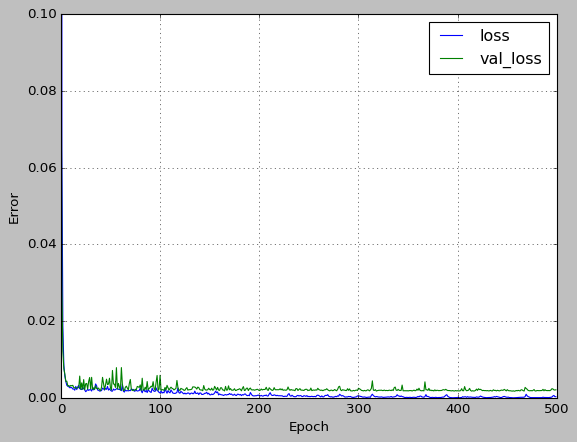

In [199]:
plot_loss(history)

In [200]:
test_results = {}
test_results['model'] = model.evaluate(X_test, y_test, verbose=2)
print (test_results)
test_results['model']

48/48 - 0s - loss: 0.0017 - 293ms/epoch - 6ms/step
{'model': 0.0016512129222974181}


0.0016512129222974181

In [201]:
y_predict= model.predict(X_test)

In [202]:
y_actual=y_test

In [203]:
y_actual = y_actual[:, np.newaxis]

C:\Users\320148~1\AppData\Local\Temp/ipykernel_9264/2145655517.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_actual = y_actual[:, np.newaxis]


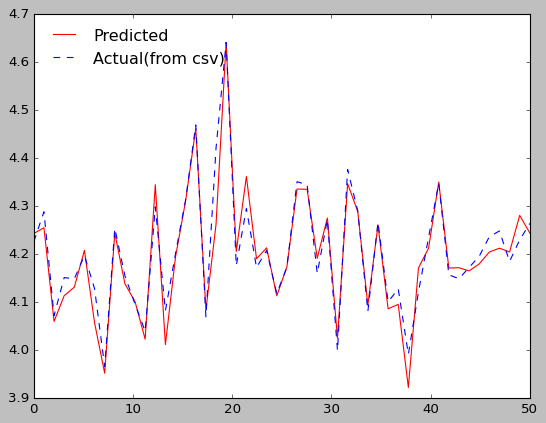

In [204]:
x=0
x_Axis = np.linspace(x, x +50 , num=50)
plt.style.use('classic')
fig, ax = plt.subplots()
ax.plot(x_Axis, y_predict[0:50,0], '-r', label='Predicted')
ax.plot(x_Axis, y_actual[0:50,0], '--b', label='Actual(from csv)')
#ax.axis('equal')
ax.legend(loc='upper left', frameon=False)
#leg = ax.legend();
fig
plt.show()

In [206]:
ann_accuracy = evaluate(model,X_test,y_actual)

Model Performance
Average Error: 0.0266 degrees.
Accuracy = 99.37%.


In [207]:
score=r2_score(y_actual,y_predict)
score

0.9209339196901667

# Linear Regression

In [177]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()

In [208]:
modelLR=LR.fit(X_train,y_train)
y_pred_LR=modelLR.predict(X_test)
scorelr=r2_score(y_actual,y_pred_LR)
scorelr

0.48797964846627506

In [209]:
lr_accuracy=evaluate(modelLR,X_test,y_test)

Model Performance
Average Error: 0.0724 degrees.
Accuracy = 98.29%.


In [210]:
mse=mean_squared_error(y_actual,y_pred_LR)
mse

0.010693006705524241

# Polynomial

In [211]:
from sklearn.preprocessing import PolynomialFeatures
PR=PolynomialFeatures(degree=4)

In [212]:
X_poly=PR.fit_transform(X_train)
LR2=LinearRegression()
LR2.fit(X_poly,y_train)

LinearRegression()

In [213]:
y_predpr=LR2.predict(PR.fit_transform(X_test))

In [214]:
scorepr=r2_score(y_actual,y_predpr)
scorepr

0.9052774058066378

In [215]:
pr_accuracy=evaluate(LR2,PR.fit_transform(X_test),y_test)

Model Performance
Average Error: 0.0304 degrees.
Accuracy = 99.28%.


# RandomForest

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [157]:
rf=RandomForestRegressor()

In [159]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [160]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [161]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [162]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [163]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [164]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [165]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train,y_train)
base_accuracy = evaluate(rf_random, X_test,y_test)

Model Performance
Average Error: 0.0279 degrees.
Accuracy = 99.34%.


In [166]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random,X_test,y_test)

Model Performance
Average Error: 0.0279 degrees.
Accuracy = 99.34%.


In [169]:
y_pred_rf=best_random.predict(X_test)

In [172]:
y_pred_rf = y_pred_rf[:, np.newaxis]

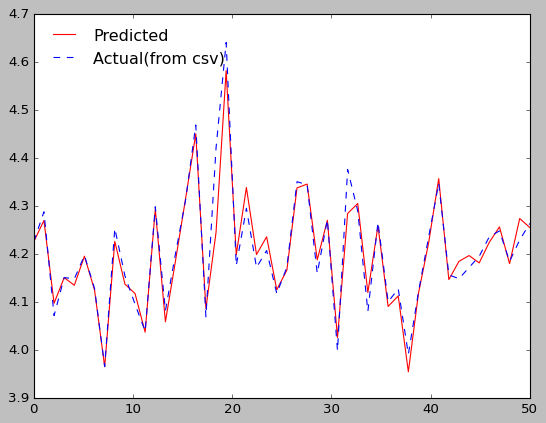

In [173]:
x=0
x_Axis = np.linspace(x, x +50 , num=50)
plt.style.use('classic')
fig, ax = plt.subplots()
ax.plot(x_Axis, y_pred_rf[0:50,0], '-r', label='Predicted')
ax.plot(x_Axis, y_actual[0:50,0], '--b', label='Actual(from csv)')
#ax.axis('equal')
ax.legend(loc='upper left', frameon=False)
#leg = ax.legend();
fig
plt.show()

In [174]:
scoreRf=r2_score(y_actual, y_pred_rf)
scoreRf

0.9164048702299187